In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
import osmnx as ox
import matplotlib.pyplot as plt
ox.config(log_file=True, log_console=True, use_cache=True)
import PyPDF2
import re
import warnings
from tqdm import tqdm
from glob import glob
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

# Creating a Luzon Boundary

In [2]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2021", 
                 password="5HOA&yn6$B", 
                 host="192.168.212.99", 
                 port=32771)

In [3]:
nominatim = Nominatim()
areaId = nominatim.query('Luzon, Philippines').areaId()

In [4]:
overpass = Overpass()
query = overpassQueryBuilder(area=areaId,
                             elementType='relation',
                             selector='"admin_level"="2.5"',
                             includeGeometry=True,out='body')
result = overpass.query(query)

In [5]:
df = pd.DataFrame(columns=['Name','geom'])
geo = gpd.read_file(str(result.elements()[0].geometry()))['geometry'][0]
df.loc[0] = [result.elements()[0].tag('name'),geo]
gdf = gpd.GeoDataFrame(df, geometry=df.geom)

# Creating the Luzon Cities

In [6]:
ph_shp = gpd.read_postgis('''
SELECT * 
FROM gadm.ph
''',conn,geom_col='geom')

In [7]:
luzon = gpd.overlay(gdf, ph_shp, how='intersection')

# Creating the Centroid of the Cities

In [8]:
luzon['centroid'] = luzon.centroid

df_luzon = luzon[['name_1','name_2','centroid']]
df_luzon  = gpd.GeoDataFrame(df_luzon , geometry=df_luzon.centroid)

# Merge Luzon with Population

In [9]:
pop = pd.read_csv('financial_pop.csv')

In [10]:
pop = pop.dropna()

In [11]:
gdf_pop = df_luzon.merge(pop,left_on=['name_1','name_2'], right_on=['shp_province','shp_municipality'])
gdf_pop = gdf_pop.dropna()

# Creating and Plotting the Substations

In [12]:
nominatim = Nominatim()
areaId = nominatim.query('Luzon,Philippines').areaId()

In [13]:
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType='way', selector='"power"="substation"', includeGeometry=True,out='body')
result = overpass.query(query)
result.countElements()

494

In [14]:
df_subs = pd.DataFrame(columns=['id','name','geom'])
for y,x in enumerate(result.elements()):
    list1 = []
    try:
        geo = gpd.read_file(str(x.geometry()))['geometry'][0]
        df_subs.loc[y] = [x.id(),x.tag('name'),geo]
    except:
        print(x.tag('name'))
        pass

In [15]:
gdf_subs = gpd.GeoDataFrame(df_subs, geometry=df_subs.geom)

# dropping the Null Names of substations

In [16]:
subs_luzon = gpd.overlay(gdf, gdf_subs, how='intersection')[['name','geometry']]
subs_luzon['centroid'] = subs_luzon.centroid
subs_luzon = subs_luzon[['name','centroid']]
subs_luzon  = gpd.GeoDataFrame(subs_luzon , geometry=subs_luzon.centroid)

#dropping none values of substation names

subs_luzon = subs_luzon[~subs_luzon['name'].isnull()]
subs_luzon['matchingname1'] = subs_luzon['name'].str.replace(' Substation','').str.lower()

In [17]:
#fig,ax = plt.subplots(1,1,figsize=(5,5))
#gdf_pop.plot(ax=ax,alpha=0.7)
#subs_luzon.plot(ax=ax,color='red');

# Creating a bounding box to limit only within the substation

In [18]:
from shapely.geometry import Point, Polygon
bbox = subs_luzon.total_bounds

p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

bb_polygon = Polygon([np1, np2, np3, np4])

df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])

df3 = gpd.overlay(df2, luzon)

df4 = df3.merge(pop,left_on=['name_1','name_2'], right_on=['shp_province','shp_municipality'])

In [19]:
#fig,ax = plt.subplots(1,1,figsize=(5,5))
#df4.plot(ax=ax,alpha=0.7)
#subs_luzon.plot(ax=ax,color='red');

# Parsing the IEMOP PDF

In [20]:
fixed_pdf = PyPDF2.PdfFileReader('datasets/energy/WESM-MNM_182.pdf')
p29 = fixed_pdf.getPage(29).extractText()
p29=p29.replace('\n4\n','\n').replace('\n3\n','\n')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p29)[0]
p29l = re.findall(r'(\n.+?\n \n.+?\n)',des)

dfa = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p29l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    dfa.loc[y] = [x1,x2]
dfa.loc[11,'name']='Santiago'
dfa=dfa.drop_duplicates()

In [21]:
p27 = fixed_pdf.getPage(27).extractText()
p27=p27.replace('\n2\n','\n').replace('\n3\n','\n')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p27)[0]
p27l = re.findall(r'(\n.+?\n \n.+?\n)',des)
df1a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p27l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df1a.loc[y] = [x1,x2]
df1a.loc[8,'name']='La Union'
df1a=df1a.drop_duplicates()

In [22]:
p28 = fixed_pdf.getPage(28).extractText()
p28=p28.replace('\n2\n','\n').replace('\n3\n','\n').replace('\n-\n','').replace(' \nPlant\n',' ')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p28)[0]
p28l = re.findall(r'(\n.+?\n \n.+?\n)',des)
df2a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p28l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df2a.loc[y] = [x1,x2]
df2a.loc[35,'name']='GN'
df2a.loc[43,'name']='San Esteban'
df2a=df2a.drop_duplicates()

In [23]:
p30 = fixed_pdf.getPage(30).extractText()
p30=p30.replace('\n2\n','\n').replace('\n3\n','\n').replace('\n-\n','').replace(' \nPlant\n',' ')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nsubject',p30)[0]
p30l = re.findall(r'(\n.+?\n \n.+?\n)',des)[:-2]
df3a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p30l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df3a.loc[y] = [x1,x2]
df3a=df3a.drop_duplicates()

In [24]:
matcher = []
for x in range(31, 41):
    pages = fixed_pdf.getPage(x).extractText()
    pages_filter = re.findall(r'\n(1[\w\_\d]*)\n \n([\w\d]*)\n', pages)
    matcher.extend(pages_filter)

for x in range(41, 56):
    pages = fixed_pdf.getPage(x).extractText()
    pages_filter = re.findall(r'\n(2[\w\_\d]*)\n \n([\w\d]*)\n', pages)
    matcher.extend(pages_filter)
    
for x in range(56, 66):
    pages = fixed_pdf.getPage(x).extractText()
    pages_filter = re.findall(r'\n(3[\w\_\d]*)\n \n([\w\d]*)\n', pages)
    matcher.extend(pages_filter)    

In [25]:
mapping = {'ambklao':'ambuklao', 'bakun':'alilem',  'balingueo':'dagupan',
          'bcnotan': 'bacnotan', 'byombng':'bayombong', 'cbntuan':'cabanatuan',
           'cncepcn': 'concepcion', 'cruzdan':'krus na daan', 'curimao':'currimao',
           'ehvsjos':'san jose del monte', 'ehvnagsaag': 'nagsaag ehv', 'latrini': 'la trinidad',
           'lbrador': 'national grid corporation of the philippines - labrador', 'nagsaag': 'nagsaag ehv',
           'bccpp':'bataan combined cycle power plant (bccpp)', 'msinloc':'masinloc', 'olongap': 'olongapo',
           'pantaba': 'pantabangan', 'snestbn':'san esteban', 'snjose':'san jose del monte',
           'snmanuel': 'san manuel', 'sntgo':'santiago', 'snroque': 'san roque',
           'tgegarao':'tuguegarao', 'salong': 'salonga',
           'caliray': 'caliraya', 'claca': 'calaca', 'dasma':'dasmariñas', 'dasmaehv': 'dasmariñas',
           'kalyaan': 'kalayaan', 'mkban':'calauan', 'mlaya': 'malaya', 'pgbilao':'pagbilao',
           'starita': 'sta rita', 'strosa': 'sta rosa', 'tayabehv': 'tayabas', 'bpc': 'bantay', 'bntay':'bantay',
           'mariveles': 'mariveles ehv', 'subic':'subic enerzone central', 'mexico':'ngcp mexico',
           'bppc': 'bauang', 'binan':'biñan', 'naga':'naga converter station', 'slpgc':'calaca'
          }

addl_matcher = pd.DataFrame(matcher).rename(columns={0:'code', 1:'name'})
addl_matcher['matchingname2'] = addl_matcher['name'].apply(lambda x: re.findall(r'[A-Za-z]+', x)[0].lower())
addl_matcher = addl_matcher.replace({"matchingname2": mapping})
addl_matcher = addl_matcher.drop_duplicates()

In [26]:
addl_matcher['code'] = addl_matcher['code'].str.split('_').apply(lambda x: x[0])

In [27]:
df4a = pd.concat([dfa,df1a,df2a,df3a]).reset_index(drop=True)
df4a['matchingname2'] = df4a['name'].str.lower()

df4a = pd.concat([df4a, addl_matcher])
df4a =df4a[['code','matchingname2']].drop_duplicates()

In [28]:
len(df4a['matchingname2'].unique())

97

# Filtering only the subsation that are in iemop

In [29]:
subs_iemop = subs_luzon[subs_luzon['matchingname1'].isin(df4a['matchingname2'])]
subs_iemop = subs_iemop.reset_index(drop=True)
len(subs_iemop)

49

In [30]:
#fig,ax = plt.subplots(1,1,figsize=(5,5))
#df4.plot(ax=ax,alpha=0.7)
#subs_iemop.plot(ax=ax,color='red');

# Determine which substation did not match

In [31]:
a = pd.merge(pd.DataFrame(subs_luzon['matchingname1']), 
         pd.DataFrame(addl_matcher['matchingname2']), 
         left_on='matchingname1', right_on='matchingname2',
         how='outer').dropna(subset=['matchingname2'])
a[a['matchingname1'].isna()]['matchingname2'].unique()

#all of these are industrial loads. 

array(['ambuklao', 'angat', 'alilem', 'dagupan', 'binga', 'burgos',
       'cascnan', 'currimao', 'cawago', 'kdam', 'magat', 'masinloc',
       'pagudpud', 'pantabangan', 'angsjo', 'santiago', 'san roque',
       'sual', 't', 'public', 'donaimelda', 'taytay', 'manila',
       'caliraya', 'salonga', 'ilijan', 'kalayaan', 'malaya', 'pagbilao',
       'mauban', 'sta rita', 'sta rosa', 'tiwi'], dtype=object)

# Getting the features within the Cities

In [32]:

provinces = ('Abra','Benguet','Rizal','Batangas','Albay','Apayao','Cavite','Aurora','Ifugao','Tarlac','La Union','Bataan',
             'Kalinga','Camarines Norte','Ilocos Norte','Cagayan','Bulacan','Pangasinan','Ilocos Sur','Catanduanes',
             'Laguna','Isabela','Marinduque','Masbate','Mountain Province','Metropolitan Manila','Nueva Ecija',
             'Nueva Vizcaya','Occidental Mindoro','Oriental Mindoro','Palawan','Pampanga','Quezon','Quirino',
             'Romblon','Sorsogon','Zambales')

amenities = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.amenity as feature,
                               count(*) AS count
                        FROM gadm.ph as g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} and p.amenity is NOT NULL
                        GROUP BY g.name_1, g.name_2, p.amenity
                        ORDER BY count DESC
                        """, conn)

In [33]:
tourism = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.tourism as feature,
                               count(*) AS count
                        FROM gadm.ph as g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.tourism IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.tourism
                        ORDER BY count DESC
                        """, conn)

In [34]:
leisure = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.leisure as feature,
                               count(*) AS count
                        FROM gadm.ph as g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.leisure IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.leisure
                        ORDER BY count DESC
                        """, conn)

In [35]:
historic = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.historic as feature,
                               count(*) AS count
                        FROM gadm.ph as g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.historic IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.historic
                        ORDER BY count DESC
                        """, conn)

In [36]:
highway = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.highway as feature,
                               count(*) AS count
                        FROM gadm.ph as g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.highway IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.highway
                        ORDER BY count DESC
                        """, conn)

In [37]:
features = pd.concat([amenities, leisure, tourism, highway, historic])

In [38]:
features = features.groupby(['name_1', 'name_2','feature']).sum()['count'].reset_index()

In [39]:
len(features.name_2.unique())

591

In [40]:
features_count = pd.pivot_table(features, values='count', 
                                 index=['name_1', 'name_2'],
                                 columns='feature' ).fillna(0).reset_index()

# Getting the Demand Energy 

In [41]:
demand = pd.read_csv('datasets/energy/energydemand.csv').dropna()

In [42]:
def clearname(x):
    x = re.findall(r'(.+)_',x)[0]
    return x

In [43]:
demand['name2'] = demand['RESOURCE_ID'].apply(clearname)

In [44]:
def clean_data(x):
    x1 = x.split('/')
    return pd.Series([x1[2],x1[0],x1[1]])

In [45]:
demand2 = demand[demand['name2'].isin(df4a['code'])]
demand3 = demand2.groupby(['name2','DELIVERY_DATE','DELIVERY_HOUR']).sum().reset_index()
demand3[['Year','Month','Day']] = demand3['DELIVERY_DATE'].apply(clean_data)
demand3['Time'] = demand3['DELIVERY_HOUR']
demand3 = demand3[['name2','Year','Month','Day','Time','MW']]

# Get only February

In [84]:
demand4 = demand3.query('Month in ["02","03","04"]')

In [85]:
demand4 = demand4[~demand4['name2'].isin(list(demand4[demand4['MW'] == 0]['name2'].unique()))]

In [86]:
demand5 = demand4.merge(df4a,left_on='name2',
              right_on='code').groupby(['matchingname2',
                                        'Year','Month',
                                        'Day',
                                        'Time']).sum().reset_index()
len(demand5['matchingname2'].unique())

58

In [87]:
subs_final = (subs_iemop[subs_iemop['matchingname1'].isin(demand5['matchingname2'])]).reset_index(drop=True)
len(subs_final)

33

# Getting the closest substation to the cities

In [88]:
c = []
df4['substation'] = None
for x in range(0,len(df4)):
    shortest_sub = subs_final.distance(df4.centroid[x]).sort_values().index[0]
    df4.loc[x,'substation'] = subs_final.loc[shortest_sub]['matchingname1']

In [89]:
len(df4['substation'].unique())

32

In [90]:
ratio1 = df4[['pop','substation']].groupby('substation').sum().to_dict()['pop']
df4['pop_total_subs'] = df4['substation'].map(ratio1)
df4['ratio_pop'] = df4['pop']/df4['pop_total_subs']
#df4[['name_2','pop','substation','ratio_pop']].head()

In [91]:
#subs_version2 = subs_luzon[subs_luzon['matchingname1'].isin(df4['substation'])]

#fig,ax = plt.subplots(1,1,figsize=(5,5))
#df4.plot(ax=ax,alpha=0.7)
#subs_version2.plot(ax=ax,color='red');

In [92]:
demand6 = demand5[demand5['matchingname2'].isin(df4['substation'])]

In [93]:
len(demand6['matchingname2'].unique())

32

# Merging all Data

In [56]:
df5 = df4[['shp_province','shp_municipality', 'substation','ratio_pop']]
#df5['code'] = df5['substation'].map(df4a[['matchingname2','code']].set_index('matchingname2').to_dict()['code'])
df5 = df5.drop_duplicates()
#df5.plot()

In [57]:
df6 = df5.merge(features_count,
                left_on=['shp_province','shp_municipality'],
                right_on=['name_1','name_2']).drop(['name_1','name_2'],axis=1)

In [58]:
working_df = demand6.merge(df6,
                           left_on=['matchingname2'],
                           right_on=['substation']).drop(['matchingname2'],axis=1)
working_df['Demand'] = working_df['MW']*working_df['ratio_pop']
working_df = working_df.drop(['MW','ratio_pop'],axis=1)
working_df[['Year','Month','Day','Time']] = working_df[['Year','Month','Day','Time']].astype('int32')

# Parse and Clean the Weather Data

In [61]:
def findspeed(x):
    try:
        x1 = re.findall(r'([0-9]+) Km/h',x)[0]
    except:
        x1 = None
    
    return x1

In [62]:
def clouds(x):
    try:
        x1 = re.findall(r' (.+?) Clouds',x)[0]
    except:
        x1 = None
    
    return x1

In [63]:
def clouds_h(x):
    try:
        x1 = re.findall(r'([0-9]+)m',x)[0]
    except:
        x1 = None
    
    return x1

In [64]:
def pres(x):
    try:
        x1 = re.findall(r'([0-9]+?)\.0mb',x)[0]
    except:
        x1 = None
    
    return x1

In [65]:
def timex(x):
    try:
        x1 = re.sub(r':[0-9][0-9]','',x)
    except:
        x1 = None
    
    return x1

In [66]:
from glob import glob
filepaths = glob('datasets/weather/*')
wf = pd.DataFrame()
for x in filepaths:
    df = pd.read_csv(x).drop(['Unnamed: 0','Unnamed: 0.1','Wind Gust','Date'],axis=1)
    df['City']= re.findall(r'weather/(.+?)_',x)[0]
    df['Time'] = df.Time.apply(timex)
    df['Temperature'] = df.Temperature.str.replace("°C",'')
    df['Relative Temperature'] = df['Relative Temperature'].str.replace("°C",'')
    df['Relative Humidity'] = df['Relative Humidity'].str.replace("%",'')
    df['Dew Point'] = df['Dew Point'].str.replace("°C",'')
    df['Pressure'] = df['Pressure'].apply(pres)
    df['Wind Speed'] = df['Wind Speed'].apply(findspeed)
    df['clouds'] = df['Condition'].apply(clouds)
    df['clods_height'] = df['Condition'].apply(clouds_h)
    df = df.drop(['Condition'],axis=1)
    wf = wf.append(df)
wf2 = wf[wf['City'].isin(df5['shp_province'])]
wf2[['Year','Month','Day','Time']] =wf2[['Year','Month','Day','Time']].astype('int32')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [frame.py:3191]


In [ ]:
wf3 = wf2.query('Month == 2')
wf3 = wf3.drop_duplicates()
wf3

In [ ]:
wf4 = wf3.copy()
for x in range(1,29):
    for x1 in range(1,24):
        for x2 in list(wf3['City'].unique()):
            try:
                wf6 = wf4.query('Day == @x and Time ==@x1 and City ==@x2').loc[0]
            except:    
                wf5 = wf3.query('City ==@x2').mode().loc[0]

                wf5['Day']=x
                wf5['Time']=x1
                wf4 = wf4.append(wf5)
                pass

In [ ]:
wf8=wf4.drop_duplicates(subset=['Year','Month','Day','Time','City'])

In [ ]:
wf9 = wf8[wf8['Time']!=0]
wf10 = wf9[wf9['Day']!=1]
wf11= wf10.reset_index()

In [ ]:
working_df1 = working_df.drop(['geometry'],axis=1)

# Get Final Dataset(Merge with working df)

In [ ]:
working_df2 = working_df1.merge(wf11,left_on=['Year','Month','Day','Time','shp_province'],
                               right_on=['Year','Month','Day','Time','City'])
working_df3 =working_df2.drop(['Year','Month','City', 'shp_province',
                               'substation','clouds','shp_municipality'],axis=1)
#dataset = working_df3.astype('float64')
#dataset = dataset.dropna()

In [76]:
working_df2.to_csv('February_Data_A.csv',index=False)

In [ ]:
working_df2.to_csv('febforfilter.csv',index=False)

In [249]:
working_df3

,Day,Time,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,Budget Accomodation,CheckPoint,Clubhouse,...,zoo,Demand,index,Temperature,Relative Temperature,Wind Speed,Relative Humidity,Dew Point,Pressure,clods_height
0,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.288228,25,25,25,4,74,20,1014,700
1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.406401,25,25,25,4,74,20,1014,700
2,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.926496,25,25,25,4,74,20,1014,700
3,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.317372,25,25,25,4,74,20,1014,700
4,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.370248,25,25,25,4,74,20,1014,700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328504,28,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.956556,499,26,28,4,84,23,1012,550
328505,28,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.135832,499,26,28,4,84,23,1012,550
328506,28,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.836942,499,26,28,4,84,23,1012,550
328507,28,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.626923,499,26,28,4,84,23,1012,550


# Time Series Analysis

In [112]:
#import lightgbm as lgb
from pandas.plotting import register_matplotlib_converters
from IPython.display import display
from tsa_functions import *

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

def rmsse(y_true, y_pred, ts):
    score = np.sqrt(np.mean((y_true - y_pred)**2)/np.mean((ts[1:] - ts[:-1])**2))
    return score

### Prepare Dataset

In [94]:
cities = pd.merge(df4[['name_1', 'name_2','substation','ratio_pop']], 
                 df4a[['code', 'matchingname2']], 
                 left_on='substation',
                 right_on='matchingname2', how='inner')

In [95]:
demand6

,matchingname2,Year,Month,Day,Time,MW
0,amadeo,2021,02,01,1.0,44.8
1,amadeo,2021,02,01,2.0,43.8
2,amadeo,2021,02,01,3.0,42.2
3,amadeo,2021,02,01,4.0,43.1
4,amadeo,2021,02,01,5.0,44.8
...,...,...,...,...,...,...
123883,tuguegarao,2021,04,30,20.0,63.1
123884,tuguegarao,2021,04,30,21.0,64.3
123885,tuguegarao,2021,04,30,22.0,66.9
123886,tuguegarao,2021,04,30,23.0,63.6


In [96]:
cities.head()

,name_1,name_2,substation,ratio_pop,code,matchingname2
0,Abra,Bangued,bantay,0.104548,1BNTAY,bantay
1,Abra,Bangued,bantay,0.104548,1BOTOL,bantay
2,Abra,Bangued,bantay,0.104548,1BPC,bantay
3,Abra,Bangued,bantay,0.104548,1BANTAY,bantay
4,Abra,Danglas,bantay,0.009100,1BNTAY,bantay


In [99]:
tsa = pd.merge(cities, demand6, left_on='matchingname2', right_on='matchingname2')
tsa['energy_demand'] = tsa['ratio_pop'] * tsa['MW']
tsa[tsa['energy_demand']==0]

,name_1,name_2,substation,ratio_pop,code,matchingname2,Year,Month,Day,Time,MW,energy_demand


In [101]:
tsa

,name_1,name_2,substation,ratio_pop,code,matchingname2,Year,Month,Day,Time,MW,energy_demand
0,Abra,Bangued,bantay,0.104548,1BNTAY,bantay,2021,02,01,1.0,14.4,1.505489
1,Abra,Bangued,bantay,0.104548,1BNTAY,bantay,2021,02,01,2.0,14.0,1.463670
2,Abra,Bangued,bantay,0.104548,1BNTAY,bantay,2021,02,01,3.0,13.2,1.380032
3,Abra,Bangued,bantay,0.104548,1BNTAY,bantay,2021,02,01,4.0,12.9,1.348667
4,Abra,Bangued,bantay,0.104548,1BNTAY,bantay,2021,02,01,5.0,13.2,1.380032
...,...,...,...,...,...,...,...,...,...,...,...,...
2800291,Zambales,Subic,olongapo,0.332983,1OLONG,olongapo,2021,04,30,20.0,62.0,20.644926
2800292,Zambales,Subic,olongapo,0.332983,1OLONG,olongapo,2021,04,30,21.0,62.6,20.844715
2800293,Zambales,Subic,olongapo,0.332983,1OLONG,olongapo,2021,04,30,22.0,63.3,21.077803
2800294,Zambales,Subic,olongapo,0.332983,1OLONG,olongapo,2021,04,30,23.0,60.5,20.145452


In [103]:
heirarchical_tsa = pd.pivot_table(tsa, values='energy_demand', 
                                 index=['Month','Day', 'Time'],
                                 columns=['name_1', 'name_2'] ).fillna(0).T
heirarchical_tsa

Month                         02                                          \
Day                           01                                           
Time                        1.0       2.0       3.0       4.0       5.0    
name_1   name_2                                                            
Abra     Bangued        1.505489  1.463670  1.380032  1.348667  1.380032   
         Boliney        0.109886  0.104745  0.099604  0.098962  0.099604   
         Bucay          0.526364  0.501739  0.477114  0.474036  0.477114   
         Bucloc         0.076917  0.073319  0.069720  0.069270  0.069720   
         Daguioman      0.064216  0.061211  0.058207  0.057832  0.058207   
...                          ...       ...       ...       ...       ...   
Zambales San Felipe     1.753586  1.716746  1.613594  1.598858  1.628330   
         San Marcelino  2.546456  2.492959  2.343167  2.321768  2.364566   
         San Narciso    2.145180  2.100113  1.973926  1.955899  1.991953   
         Santa Cruz     2.220567  2.123445  2.008664  1.968932  1.999835   
         Subic          7.924988  7.758496  7.292321  7.225724  7.358917   

Month                                                                     ...  \
Day                                                                       ...   
Time                        6.0       7.0       8.0       9.0       10.0  ...   
name_1   name_2                                                           ...   
Abra     Bangued        1.474125  1.630946  1.704130  1.787768  2.007319  ...   
         Boliney        0.108601  0.126594  0.148443  0.145872  0.156154  ...   
         Bucay          0.520208  0.606396  0.711054  0.698741  0.747992  ...   
         Bucloc         0.076018  0.088612  0.103906  0.102106  0.109303  ...   
         Daguioman      0.063464  0.073979  0.086747  0.085245  0.091254  ...   
...                          ...       ...       ...       ...       ...  ...   
Zambales San Felipe     1.679906  1.738850  1.834634  1.945155  2.151459  ...   
         San Marcelino  2.439462  2.525057  2.664149  2.824640  3.124223  ...   
         San Narciso    2.055046  2.127153  2.244327  2.379527  2.631901  ...   
         Santa Cruz     2.074884  2.255884  2.339762  2.472202  2.790056  ...   
         Subic          7.592005  7.858391  8.291269  8.790743  9.723094  ...   

Month                          04                                              \
Day                            30                                               
Time                         15.0       16.0       17.0       18.0       19.0   
name_1   name_2                                                                 
Abra     Bangued         2.801882   2.739154   2.509148   2.268688   2.310508   
         Boliney         0.203707   0.195353   0.195353   0.178645   0.186356   
         Bucay           0.975775   0.935759   0.935759   0.855727   0.892665   
         Bucloc          0.142589   0.136742   0.136742   0.125047   0.130444   
         Daguioman       0.119043   0.114161   0.114161   0.104397   0.108904   
...                           ...        ...        ...        ...        ...   
Zambales San Felipe      4.803942   4.752366   4.376598   4.126085   4.406070   
         San Marcelino   6.976005   6.901109   6.355440   5.991660   6.398237   
         San Narciso     5.876711   5.813618   5.353937   5.047482   5.389990   
         Santa Cruz      4.763403   4.600061   4.154182   3.730376   3.721547   
         Subic          21.710470  21.477382  19.779171  18.647030  19.912364   

Month                                                                          
Day                                                                            
Time                         20.0       21.0       22.0       23.0       24.0  
name_1   name_2                                                                
Abra     Bangued         2.582332   2.739154   2.833247   2.718244   2.488239  
         Boliney         0.

### Split Train-Test

In [105]:
tsa_train = heirarchical_tsa.iloc[:, 1008:2137].T
tsa_train.head()

name_1              Abra                                                    \
name_2           Bangued   Boliney     Bucay    Bucloc Daguioman   Danglas   
Month Day Time                                                               
03    15  1.0   2.279143  0.172862  0.828024  0.120998  0.101017  0.198372   
          2.0   2.153686  0.163865  0.784929  0.114701  0.095760  0.187452   
          3.0   2.111867  0.160010  0.766460  0.112002  0.093507  0.183812   
          4.0   2.038683  0.152941  0.732601  0.107054  0.089376  0.177442   
          5.0   2.059593  0.154226  0.738757  0.107954  0.090127  0.179262   

name_1                                                    ...  Zambales  \
name_2           Dolores    La Paz     Lacub Lagangilang  ...       Iba   
Month Day Time                                            ...             
03    15  1.0   0.535442  0.730501  0.161035    0.674567  ...  0.572471   
          2.0   0.505968  0.690290  0.152171    0.637435  ...  0.576502   
          3.0   0.496144  0.676887  0.149216    0.625058  ...  0.580534   
          4.0   0.478951  0.653430  0.144045    0.603397  ...  0.584565   
          5.0   0.483863  0.660132  0.145522    0.609586  ...  0.608754   

name_1                                                                   \
name_2          Masinloc Olongapo City   Palauig San Antonio San Felipe   
Month Day Time                                                            
03    15  1.0   2.945239      1.805803  0.396114    4.637712   3.101932   
          2.0   2.778596      1.735447  0.398904    4.483488   2.998780   
          3.0   2.666293      1.735447  0.401693    4.263169   2.851420   
          4.0   2.557613      1.758899  0.404483    4.130978   2.763004   
          5.0   2.525008      1.782351  0.421220    4.153010   2.777740   

name_1                                                          
name_2         San Marcelino San Narciso Santa Cruz      Subic  
Month Day Time                                                  
03    15  1.0       4.504445    3.794625   3.589107  14.018571  
          2.0       4.354653    3.668438   3.386034  13.552395  
          3.0       4.140665    3.488171   3.249180  12.886429  
          4.0       4.012273    3.380010   3.116740  12.486850  
          5.0       4.033671    3.398037   3.077008  12.553447  

[5 rows x 636 columns]

In [106]:
tsa_test = heirarchical_tsa.iloc[:, 2137:].T
tsa_test.head()

Empty DataFrame
Columns: [(Abra, Bangued), (Abra, Boliney), (Abra, Bucay), (Abra, Bucloc), (Abra, Daguioman), (Abra, Danglas), (Abra, Dolores), (Abra, La Paz), (Abra, Lacub), (Abra, Lagangilang), (Abra, Lagayan), (Abra, Langiden), (Abra, Licuan-Baay), (Abra, Luba), (Abra, Malibcong), (Abra, Manabo), (Abra, Peñarrubia), (Abra, Pidigan), (Abra, Pilar), (Abra, Sallapadan), (Abra, San Isidro), (Abra, San Juan), (Abra, San Quintin), (Abra, Tayum), (Abra, Tineg), (Abra, Tubo), (Abra, Villaviciosa), (Albay, Bacacay), (Albay, Camalig), (Albay, Daraga), (Albay, Guinobatan), (Albay, Jovellar), (Albay, Legazpi City), (Albay, Libon), (Albay, Ligao City), (Albay, Malilipot), (Albay, Malinao), (Albay, Manito), (Albay, Oas), (Albay, Pio Duran), (Albay, Polangui), (Albay, Rapu-Rapu), (Albay, Santo Domingo), (Albay, Tabaco City), (Albay, Tiwi), (Apayao, Calanasan), (Apayao, Conner), (Apayao, Flora), (Apayao, Kabugao), (Apayao, Luna), (Apayao, Pudtol), (Aurora, Baler), (Aurora, Casiguran), (Aurora, Dilasag), (Aurora, Dinalungan), (Aurora, Dingalan), (Aurora, Dipaculao), (Aurora, Maria Aurora), (Aurora, San Luis), (Bataan, Abucay), (Bataan, Bagac), (Bataan, Balanga City), (Bataan, Dinalupihan), (Bataan, Hermosa), (Bataan, Limay), (Bataan, Mariveles), (Bataan, Morong), (Bataan, Orani), (Bataan, Orion), (Bataan, Pilar), (Bataan, Samal), (Batangas, Agoncillo), (Batangas, Alitagtag), (Batangas, Balayan), (Batangas, Balete), (Batangas, Batangas City), (Batangas, Bauan), (Batangas, Calaca), (Batangas, Calatagan), (Batangas, Cuenca), (Batangas, Ibaan), (Batangas, Laurel), (Batangas, Lemery), (Batangas, Lian), (Batangas, Lipa City), (Batangas, Lobo), (Batangas, Mabini), (Batangas, Malvar), (Batangas, Mataas Na Kahoy), (Batangas, Nasugbu), (Batangas, Padre Garcia), (Batangas, Rosario), (Batangas, San Jose), (Batangas, San Juan), (Batangas, San Luis), (Batangas, San Nicolas), (Batangas, San Pascual), (Batangas, Santa Teresita), (Batangas, Santo Tomas), (Batangas, Taal), ...]
Index: []

[0 rows x 636 columns]

In [81]:
# features = tsa_train.copy()
# features

### Prepare Exogenous Variables

In [107]:
features = pd.merge(features_count, df4[['shp_province', 'shp_municipality']],
         left_on=['name_1', 'name_2'], right_on=['shp_province', 'shp_municipality'], how='right').fillna(0).set_index(['shp_province', 'shp_municipality'])
features

name_1         name_2  BPI ATM  \
shp_province shp_municipality                                     
Abra         Bangued               Abra        Bangued      0.0   
             Boliney                  0              0      0.0   
             Bucay                    0              0      0.0   
             Bucloc                   0              0      0.0   
             Daguioman                0              0      0.0   
...                                 ...            ...      ...   
Zambales     Palauig           Zambales        Palauig      0.0   
             San Antonio       Zambales    San Antonio      0.0   
             San Felipe        Zambales     San Felipe      0.0   
             San Marcelino     Zambales  San Marcelino      0.0   
             Subic             Zambales          Subic      0.0   

                               Barangay Hall  Barangay Yakal Hall  \
shp_province shp_municipality                                       
Abra         Bangued                     0.0                  0.0   
             Boliney                     0.0                  0.0   
             Bucay                       0.0                  0.0   
             Bucloc                      0.0                  0.0   
             Daguioman                   0.0                  0.0   
...                                      ...                  ...   
Zambales     Palauig                     0.0                  0.0   
             San Antonio                 0.0                  0.0   
             San Felipe                  0.0                  0.0   
             San Marcelino               0.0                  0.0   
             Subic                       0.0                  0.0   

                               Barangay_Police_Outpost  Basketball Court  \
shp_province shp_municipality                                              
Abra         Bangued                               0.0               0.0   
             Boliney                               0.0               0.0   
             Bucay                                 0.0               0.0   
             Bucloc                                0.0               0.0   
             Daguioman                             0.0               0.0   
...                                                ...               ...   
Zambales     Palauig                               0.0               0.0   
             San Antonio                           0.0               0.0   
             San Felipe                            0.0               0.0   
             San Marcelino                         0.0               0.0   
             Subic                                 0.0               0.0   

                               Budget Accomodation  CheckPoint  Clubhouse  \
shp_province shp_municipality                                               
Abra         Bangued                           0.0         0.0        0.0   
             Boliney                           0.0         0.0        0.0   
             Bucay                             0.0         0.0        0.0   
             Bucloc                            0.0         0.0        0.0   
             Daguioman                         0.0         0.0        0.0   
...                                            ...         ...        ...   
Zambales     Palauig                           0.0         0.0        0.0   
             San Antonio                       0.0         0.0        0.0   
             San Felipe                        0.0         0.0        0.0   
             San Marcelino                     0.0         0.0        0.0   
             Subic                             0.0         0.0        0.0   

                               ...  waterwell  wayside_cross  wayside_shrine  \
shp_province shp_municipality  ...                                             
Abra         Bangued           ...        0.0            0.0             0.0   
             Boliney           .

In [86]:
# top_features = list(f.index)
# top_features.remove('Time')
# top_features.remove('Day')

In [108]:
# exogenous_data = features[top_features].T
exogenous_data = features.iloc[:,2:].T
exogenous_data

shp_province               Abra                                           \
shp_municipality        Bangued Boliney Bucay Bucloc Daguioman Malibcong   
BPI ATM                     0.0     0.0   0.0    0.0       0.0       0.0   
Barangay Hall               0.0     0.0   0.0    0.0       0.0       0.0   
Barangay Yakal Hall         0.0     0.0   0.0    0.0       0.0       0.0   
Barangay_Police_Outpost     0.0     0.0   0.0    0.0       0.0       0.0   
Basketball Court            0.0     0.0   0.0    0.0       0.0       0.0   
...                         ...     ...   ...    ...       ...       ...   
wheeler                     0.0     0.0   0.0    0.0       0.0       0.0   
wilderness_hut              0.0     0.0   0.0    0.0       0.0       0.0   
wrecker_service             0.0     0.0   0.0    0.0       0.0       0.0   
yes                         0.0     0.0   0.0    0.0       0.0       0.0   
zoo                         0.0     0.0   0.0    0.0       0.0       0.0   

shp_province                                          ...   Zambales  \
shp_municipality        Danglas Dolores La Paz Lacub  ... Santa Cruz   
BPI ATM                     0.0     0.0    0.0   0.0  ...        0.0   
Barangay Hall               0.0     0.0    0.0   0.0  ...        0.0   
Barangay Yakal Hall         0.0     0.0    0.0   0.0  ...        0.0   
Barangay_Police_Outpost     0.0     0.0    0.0   0.0  ...        0.0   
Basketball Court            0.0     0.0    0.0   0.0  ...        0.0   
...                         ...     ...    ...   ...  ...        ...   
wheeler                     0.0     0.0    0.0   0.0  ...        0.0   
wilderness_hut              0.0     0.0    0.0   0.0  ...        0.0   
wrecker_service             0.0     0.0    0.0   0.0  ...        0.0   
yes                         0.0     0.0    0.0   0.0  ...        0.0   
zoo                         0.0     0.0    0.0   0.0  ...        0.0   

shp_province                                                            \
shp_municipality        Candelaria  Iba Masinloc Olongapo City Palauig   
BPI ATM                        0.0  0.0      0.0           0.0     0.0   
Barangay Hall                  0.0  0.0      0.0           0.0     0.0   
Barangay Yakal Hall            0.0  0.0      0.0           0.0     0.0   
Barangay_Police_Outpost        0.0  0.0      0.0           0.0     0.0   
Basketball Court               0.0  0.0      0.0           0.0     0.0   
...                            ...  ...      ...           ...     ...   
wheeler                        0.0  0.0      0.0           0.0     0.0   
wilderness_hut                 0.0  0.0      0.0           0.0     0.0   
wrecker_service                0.0  0.0      0.0           0.0     0.0   
yes                            0.0  0.0      0.0           0.0     0.0   
zoo                            0.0  0.0      0.0           0.0     0.0   

shp_province                                                        
shp_municipality        San Antonio San Felipe San Marcelino Subic  
BPI ATM                         0.0        0.0           0.0   0.0  
Barangay Hall                   0.0        0.0           0.0   0.0  
Barangay Yakal Hall             0.0        0.0           0.0   0.0  
Barangay_Police_Outpost         0.0        0.0           0.0   0.0  
Basketball Court                0.0        0.0           0.0   0.0  
...                             ...        ...           ...   ...  
wheeler                         0.0        0.0           0.0   0.0  
wilderness_hut                  0.0        0.0           0.0   0.0  
wrecker_service                 0.0        0.0           0.0   0.0  
yes                             0.0        0.0           0.0   0.0  
zoo                             0.0        0.0           0.0   0.0  

[352 rows x 636 columns]

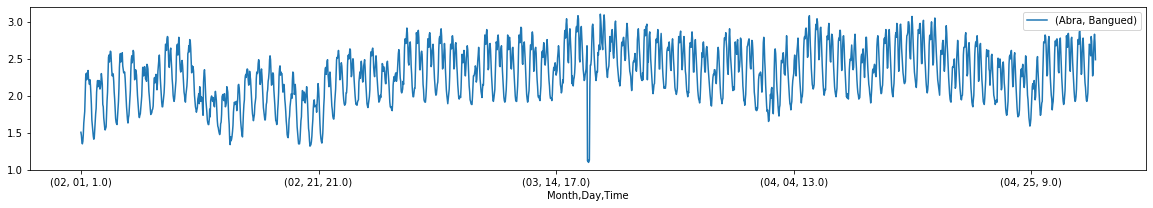

In [109]:
series = heirarchical_tsa.iloc[0]

series.plot(figsize=(20,3))
plt.legend()
plt.show()

### Direct Forecasting

In [89]:
# def split_arrays(series, test_size, w, h):
#     ts_train = series[:-test_size]
#     ts_test = series[-test_size-w:]
#     return ts_train, ts_test

In [90]:
# def create_feature_target(series, w, h):
#     features, target = [], []
#     for i in range(len(series)-w-h+1):
#         features.append(series[i:i+w])
#         target.append(series[i+w: i+w+h])
#     return np.array(features), np.array(target)

In [187]:
# from sklearn.multioutput import MultiOutputRegressor
# w = 1*24
# def direct_forecasting(train, val_size, h):
#     rmse_mat = []
#     for i in range(val_size, h-1, -1):
#         ts_train = train[:-i].to_numpy()
#         if i == h:
#             ts_val = train[-i-w:].to_numpy()
#         else: 
#             ts_val = train[-i-w:-i+h].to_numpy()

#         train_features, train_target = create_feature_target(ts_train, w, h)
#         val_features, val_target = create_feature_target(ts_val, w, h)

#         model = MultiOutputRegressor(lgb.LGBMRegressor(random_state=1), n_jobs = -1)
#         model.fit(train_features, train_target)

#         forecast_direct = model.predict(val_features)

#         rmse_mat.append(rmse(val_target, forecast_direct))

#     avg_rmse = np.nanmean(np.asarray(rmse_mat), axis=0)
#     std_rmse = np.nanstd(np.asarray(rmse_mat), axis=0)
 
#     return forecast_direct, avg_rmse, std_rmse                                                            

In [101]:
# train = tsa_train.iloc[:,-8]
# val_size = 24
# h = 12

# forecast_direct, avg_rmse, std_rmse = direct_forecasting(train, val_size, h)
# forecast_direct, avg_rmse, std_rmse

(array([[ 0.52515573,  0.66785137,  0.91311536,  1.125023  ,  1.03315509,
          0.62370945, -0.09464494,  0.90034593,  0.22458895,  0.52648564,
          0.65853831,  0.69050174]]),
 0.31794923790559604,
 0.09344731493061499)

In [102]:
# def create_feature_target_with_exogenous(series, exo, w, h):
#     features, exo_features, target = [], [], []
#     for i in range(len(series)-w-h+1):
#         features.append(series[i:i+w])
#         target.append(series[i+w: i+w+h])
    
#     for i in range(np.array(features).shape[0]):
#         exo_features.append(exo)
#     return np.concatenate((features, exo_features), axis=1), np.array(target)

In [103]:
# from sklearn.multioutput import MultiOutputRegressor
# w = 1*24
# def direct_forecasting_with_exogenous(train, exo, val_size, h):
#     rmse_mat = []
#     for i in range(val_size, h-1, -1):
#         ts_train = train[:-i].to_numpy()
#         if i == h:
#             ts_val = train[-i-w:].to_numpy()
#         else: 
#             ts_val = train[-i-w:-i+h].to_numpy()

#         train_features, train_target = create_feature_target_with_exogenous(ts_train, exo, w, h)
#         val_features, val_target = create_feature_target_with_exogenous(ts_val, exo, w, h)

#         model = MultiOutputRegressor(lgb.LGBMRegressor(random_state=1), n_jobs = -1)
#         model.fit(train_features, train_target)

#         forecast_direct = model.predict(val_features)

#         rmse_mat.append(rmse(val_target, forecast_direct))

#     avg_rmse = np.nanmean(np.asarray(rmse_mat), axis=0)
#     std_rmse = np.nanstd(np.asarray(rmse_mat), axis=0)
 
#     return forecast_direct, avg_rmse, std_rmse                                                            

In [104]:
# train = tsa_train.iloc[:,-8]
# exo = exogenous_data.iloc[:,-6]
# val_size = 24
# h = 12

# forecast_direct, avg_rmse, std_rmse = direct_forecasting_with_exogenous(train, exo, val_size, h)
# forecast_direct, avg_rmse, std_rmse

(array([[ 0.52515573,  0.66785137,  0.91311536,  1.125023  ,  1.03315509,
          0.62370945, -0.09464494,  0.90034593,  0.22458895,  0.52648564,
          0.65853831,  0.69050174]]),
 0.31794923790559604,
 0.09344731493061499)

### Time Series Decomposition

In [113]:
df = pd.DataFrame()
for index in heirarchical_tsa.index:
    series = heirarchical_tsa.loc[index,:]
    res = STL(series.to_numpy(), period=24, seasonal=25, robust=True).fit()
    seasonal_daily = res.seasonal
    df = pd.concat([df, pd.DataFrame(seasonal_daily).T], axis=0)
df

,0,1,2,3,4,5,6,7,8,9,...,2126,2127,2128,2129,2130,2131,2132,2133,2134,2135
0,-0.316169,-0.397137,-0.475478,-0.521861,-0.498944,-0.434071,-0.316998,-0.212394,-0.108582,0.146008,...,0.397307,0.321179,0.107989,-0.106534,-0.089549,0.183126,0.318192,0.361236,0.186863,-0.001118
0,-0.028372,-0.035960,-0.041034,-0.044252,-0.044005,-0.037031,-0.022069,-0.002630,-0.002255,0.009299,...,0.025869,0.015614,-0.006636,-0.020647,-0.011504,0.036187,0.050209,0.045596,0.027162,0.005954
0,-0.135906,-0.172253,-0.196559,-0.211971,-0.210788,-0.177384,-0.105712,-0.012599,-0.010801,0.044541,...,0.123914,0.074791,-0.031786,-0.098903,-0.055105,0.173341,0.240505,0.218409,0.130109,0.028521
0,-0.019860,-0.025171,-0.028723,-0.030975,-0.030802,-0.025921,-0.015448,-0.001841,-0.001578,0.006509,...,0.018107,0.010929,-0.004645,-0.014453,-0.008052,0.025330,0.035145,0.031916,0.019013,0.004168
0,-0.016580,-0.021015,-0.023980,-0.025860,-0.025716,-0.021640,-0.012897,-0.001537,-0.001318,0.005434,...,0.015117,0.009124,-0.003878,-0.012066,-0.006723,0.021147,0.029341,0.026645,0.015873,0.003479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.298365,-0.393757,-0.481977,-0.535806,-0.519883,-0.476905,-0.426697,-0.359450,-0.254099,-0.019143,...,0.621177,0.510754,0.185118,0.003532,0.329160,0.485700,0.596094,0.653624,0.355802,0.102738
0,-0.433269,-0.571791,-0.699899,-0.778066,-0.754944,-0.692533,-0.619625,-0.521972,-0.368988,-0.027798,...,0.902037,0.741687,0.268818,0.005129,0.477987,0.705305,0.865613,0.949155,0.516674,0.149190
0,-0.364993,-0.481687,-0.589607,-0.655457,-0.635979,-0.583402,-0.521983,-0.439718,-0.310842,-0.023418,...,0.759892,0.624810,0.226457,0.004321,0.402665,0.594162,0.729208,0.799585,0.435256,0.125681
0,-0.347368,-0.513967,-0.637794,-0.727234,-0.743744,-0.721527,-0.616426,-0.568446,-0.437593,-0.027391,...,0.737697,0.612332,0.179342,-0.261304,-0.314516,0.300313,0.665953,0.738929,0.513913,0.186293


In [114]:
df.index = heirarchical_tsa.index
df.to_csv('decomposed_daily_seasonal_A.csv')

In [115]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_new = scaler.fit_transform(df.T)
df_new = pd.DataFrame(df_new)
df_new.columns = df.T.columns
df_new = df_new.T
df_new

0         1         2         3         4     \
name_1   name_2                                                            
Abra     Bangued        0.212943  0.129121  0.048018  0.000000  0.023725   
         Boliney        0.164958  0.086133  0.033422  0.000000  0.002565   
         Bucay          0.164958  0.086133  0.033422  0.000000  0.002565   
         Bucloc         0.164958  0.086133  0.033422  0.000000  0.002565   
         Daguioman      0.164958  0.086133  0.033422  0.000000  0.002565   
...                          ...       ...       ...       ...       ...   
Zambales San Felipe     0.368251  0.307900  0.252087  0.218031  0.228104   
         San Marcelino  0.368251  0.307900  0.252087  0.218031  0.228104   
         San Narciso    0.368251  0.307900  0.252087  0.218031  0.228104   
         Santa Cruz     0.345033  0.252719  0.184106  0.134547  0.125399   
         Subic          0.368251  0.307900  0.252087  0.218031  0.228104   

                            5         6         7         8         9     ...  \
name_1   name_2                                                           ...   
Abra     Bangued        0.090885  0.212085  0.320377  0.427848  0.691413  ...   
         Boliney        0.075007  0.230438  0.432368  0.436267  0.556285  ...   
         Bucay          0.075007  0.230438  0.432368  0.436267  0.556285  ...   
         Bucloc         0.075007  0.230438  0.432368  0.436267  0.556285  ...   
         Daguioman      0.075007  0.230438  0.432368  0.436267  0.556285  ...   
...                          ...       ...       ...       ...       ...  ...   
Zambales San Felipe     0.255296  0.287060  0.329605  0.396256  0.544904  ...   
         San Marcelino  0.255296  0.287060  0.329605  0.396256  0.544904  ...   
         San Narciso    0.255296  0.287060  0.329605  0.396256  0.544904  ...   
         Santa Cruz     0.137709  0.195946  0.222532  0.295039  0.522335  ...   
         Subic          0.255296  0.287060  0.329605  0.396256  0.544904  ...   

                            2126      2127      2128      2129      2130  \
name_1   name_2                                                            
Abra     Bangued        0.951572  0.872760  0.652054  0.429968  0.447553   
         Boliney        0.728417  0.621887  0.390759  0.245205  0.340187   
         Bucay          0.728417  0.621887  0.390759  0.245205  0.340187   
         Bucloc         0.728417  0.621887  0.390759  0.245205  0.340187   
         Daguioman      0.728417  0.621887  0.390759  0.245205  0.340187   
...                          ...       ...       ...       ...       ...   
Zambales San Felipe     0.950010  0.880150  0.674132  0.559250  0.765262   
         San Marcelino  0.950010  0.880150  0.674132  0.559250  0.765262   
         San Narciso    0.950010  0.880150  0.674132  0.559250  0.765262   
         Santa Cruz     0.946276  0.876810  0.636887  0.392722  0.363237   
         Subic          0.950010  0.880150  0.674132  0.559250  0.765262   

                            2131      2132      2133      2134      2135  
name_1   name_2                                                           
Abra     Bangued        0.729840  0.869668  0.914229  0.733709  0.539101  
         Boliney        0.835607  0.981263  0.933344  0.741852  0.521543  
         Bucay          0.835607  0.981263  0.933344  0.741852  0.521543  
         Bucloc         0.835607  0.981263  0.933344  0.741852  0.521543  
         Daguioman      0.835607  0.981263  0.933344  0.741852  0.521543  
...                          ...       ...       ...       ...       ...  
Zambales San Felipe     0.864299  0.934141  0.970538  0.782117  0.622014  
         San Marcelino  0.864299  0.934141  0.970538  0.782117  0.622014  
         San Narciso    0.864299  0.934141  0.970538  0.782117  0.622014  
         Santa Cruz     0.703918  0.906522  0.946958  0.822275  0.640739  
         Subic          0.864299  0.934141  0.970538  0.782117  0.622014  

[636 rows x 2136 col

In [142]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=2)
y_predict = agg.fit_predict(df_new)
df_new['clustering'] = y_predict
df_new

0         1         2         3         4  \
name_1   name_2                                                            
Abra     Bangued        0.212943  0.129121  0.048018  0.000000  0.023725   
         Boliney        0.164958  0.086133  0.033422  0.000000  0.002565   
         Bucay          0.164958  0.086133  0.033422  0.000000  0.002565   
         Bucloc         0.164958  0.086133  0.033422  0.000000  0.002565   
         Daguioman      0.164958  0.086133  0.033422  0.000000  0.002565   
...                          ...       ...       ...       ...       ...   
Zambales San Felipe     0.368251  0.307900  0.252087  0.218031  0.228104   
         San Marcelino  0.368251  0.307900  0.252087  0.218031  0.228104   
         San Narciso    0.368251  0.307900  0.252087  0.218031  0.228104   
         Santa Cruz     0.345033  0.252719  0.184106  0.134547  0.125399   
         Subic          0.368251  0.307900  0.252087  0.218031  0.228104   

                               5         6         7         8         9  ...  \
name_1   name_2                                                           ...   
Abra     Bangued        0.090885  0.212085  0.320377  0.427848  0.691413  ...   
         Boliney        0.075007  0.230438  0.432368  0.436267  0.556285  ...   
         Bucay          0.075007  0.230438  0.432368  0.436267  0.556285  ...   
         Bucloc         0.075007  0.230438  0.432368  0.436267  0.556285  ...   
         Daguioman      0.075007  0.230438  0.432368  0.436267  0.556285  ...   
...                          ...       ...       ...       ...       ...  ...   
Zambales San Felipe     0.255296  0.287060  0.329605  0.396256  0.544904  ...   
         San Marcelino  0.255296  0.287060  0.329605  0.396256  0.544904  ...   
         San Narciso    0.255296  0.287060  0.329605  0.396256  0.544904  ...   
         Santa Cruz     0.137709  0.195946  0.222532  0.295039  0.522335  ...   
         Subic          0.255296  0.287060  0.329605  0.396256  0.544904  ...   

                            2127      2128      2129      2130      2131  \
name_1   name_2                                                            
Abra     Bangued        0.872760  0.652054  0.429968  0.447553  0.729840   
         Boliney        0.621887  0.390759  0.245205  0.340187  0.835607   
         Bucay          0.621887  0.390759  0.245205  0.340187  0.835607   
         Bucloc         0.621887  0.390759  0.245205  0.340187  0.835607   
         Daguioman      0.621887  0.390759  0.245205  0.340187  0.835607   
...                          ...       ...       ...       ...       ...   
Zambales San Felipe     0.880150  0.674132  0.559250  0.765262  0.864299   
         San Marcelino  0.880150  0.674132  0.559250  0.765262  0.864299   
         San Narciso    0.880150  0.674132  0.559250  0.765262  0.864299   
         Santa Cruz     0.876810  0.636887  0.392722  0.363237  0.703918   
         Subic          0.880150  0.674132  0.559250  0.765262  0.864299   

                            2132      2133      2134      2135  clustering  
name_1   name_2                                                             
Abra     Bangued        0.869668  0.914229  0.733709  0.539101           0  
         Boliney        0.981263  0.933344  0.741852  0.521543           0  
         Bucay          0.981263  0.933344  0.741852  0.521543           0  
         Bucloc         0.981263  0.933344  0.741852  0.521543           0  
         Daguioman      0.981263  0.933344  0.741852  0.521543           0  
...                          ...       ...       ...       ...         ...  
Zambales San Felipe     0.934141  0.970538  0.782117  0.622014           0  
         San Marcelino  0.934141  0.970538  0.782117  0.622014           0  
         San Narciso    0.934141  0.970538  0.782117  0.622014           0  
         Santa Cruz     0.906522  0.946958  0.822275  0.640739           0  
         Subic          0.934141  0.970538  0.782117  0.622014           0 

### Sample Decomposed Data

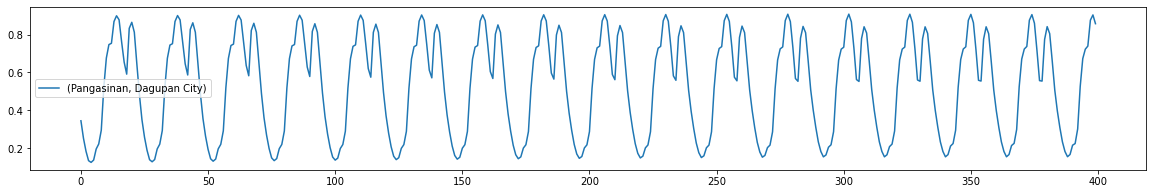

In [143]:
series = df_new[df_new['clustering']==0].sample(1).iloc[0,:400]

series.plot(figsize=(20,3))
plt.legend()
plt.show()

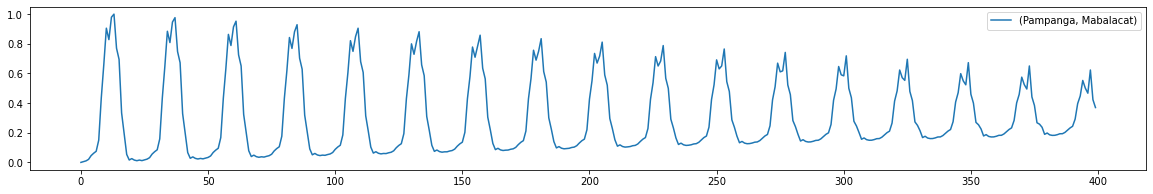

In [144]:
series = df_new[df_new['clustering']==1].sample(1).iloc[0,:400]

series.plot(figsize=(20,3))
plt.legend()
plt.show()

In [145]:
series = df_new[df_new['clustering']==2].sample(1).iloc[0,:400]

series.plot(figsize=(20,3))
plt.legend()
plt.show()

ValueError: a must be greater than 0 unless no samples are taken

In [135]:
series = df_new[df_new['clustering']==3].sample(1).iloc[0,:400]

series.plot(figsize=(20,3))
plt.legend()
plt.show()

ValueError: a must be greater than 0 unless no samples are taken

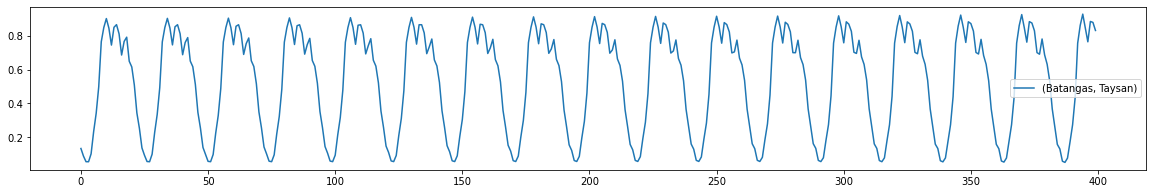

In [121]:
series = df_new[df_new['clustering']==4].sample(1).iloc[0,:400]

series.plot(figsize=(20,3))
plt.legend()
plt.show()

### Classification

In [146]:
final_df = exogenous_data[heirarchical_tsa.index].T
final_df['classification'] = df_new['clustering']
final_df

BPI ATM  Barangay Hall  Barangay Yakal Hall  \
shp_province shp_municipality                                                
Abra         Bangued               0.0            0.0                  0.0   
             Boliney               0.0            0.0                  0.0   
             Bucay                 0.0            0.0                  0.0   
             Bucloc                0.0            0.0                  0.0   
             Daguioman             0.0            0.0                  0.0   
...                                ...            ...                  ...   
Zambales     San Felipe            0.0            0.0                  0.0   
             San Marcelino         0.0            0.0                  0.0   
             San Narciso           0.0            0.0                  0.0   
             Santa Cruz            0.0            0.0                  0.0   
             Subic                 0.0            0.0                  0.0   

                               Barangay_Police_Outpost  Basketball Court  \
shp_province shp_municipality                                              
Abra         Bangued                               0.0               0.0   
             Boliney                               0.0               0.0   
             Bucay                                 0.0               0.0   
             Bucloc                                0.0               0.0   
             Daguioman                             0.0               0.0   
...                                                ...               ...   
Zambales     San Felipe                            0.0               0.0   
             San Marcelino                         0.0               0.0   
             San Narciso                           0.0               0.0   
             Santa Cruz                            0.0               0.0   
             Subic                                 0.0               0.0   

                               Budget Accomodation  CheckPoint  Clubhouse  \
shp_province shp_municipality                                               
Abra         Bangued                           0.0         0.0        0.0   
             Boliney                           0.0         0.0        0.0   
             Bucay                             0.0         0.0        0.0   
             Bucloc                            0.0         0.0        0.0   
             Daguioman                         0.0         0.0        0.0   
...                                            ...         ...        ...   
Zambales     San Felipe                        0.0         0.0        0.0   
             San Marcelino                     0.0         0.0        0.0   
             San Narciso                       0.0         0.0        0.0   
             Santa Cruz                        0.0         0.0        0.0   
             Subic                             0.0         0.0        0.0   

                               Dive_School  Driving  ...  wayside_cross  \
shp_province shp_municipality                        ...                  
Abra         Bangued                   0.0      0.0  ...            0.0   
             Boliney                   0.0      0.0  ...            0.0   
             Bucay                     0.0      0.0  ...            0.0   
             Bucloc                    0.0      0.0  ...            0.0   
             Daguioman                 0.0      0.0  ...            0.0   
...                                    ...      ...  ...            ...   
Zambales     San Felipe                0.0      0.0  ...            0.0   
             San Marcelino             0.0      0.0  ...            0.0   
             San Narciso               0.0      0.0  ...            0.0   
             Santa Cruz                0.0      0.0  ...            0.0   
             Subic                     0.0      0.0  ...            0.0   

                               wayside_shrine  we

In [126]:
final_df.to_csv('classification_dataset.csv',index=False)

In [153]:
y

ExtraTreesClassifier()

In [147]:
from sklearn.model_selection import train_test_split

X = final_df.drop(['classification'],axis=1)
y = final_df['classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,stratify=y)


In [149]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [150]:
#KNN
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

#Decision Tree
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

# Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

#Gradient Boosting Regressor
GBM = GradientBoostingClassifier()
GBM.fit(X_train, y_train)

# Extra Trees
ET = ExtraTreesClassifier()
ET.fit(X_train, y_train)

ExtraTreesClassifier()

In [154]:
ml_list = [KNN,DT,RF,GBM,ET]
ml_name = ['KNN', 'Decision Tree','Random Forest','GBM','Extra Trees']
df_acc = pd.DataFrame(columns=['Names','Train Accuracy',"Test Accuracy"])
count = 0
for x1,y1 in zip(ml_name,ml_list):
    df_acc.loc[count] = [x1,y1.score(X_train,y_train),y1.score(X_test,y_test)]
    count +=1    
df_acc

,Names,Train Accuracy,Test Accuracy
0,KNN,0.813417,0.767296
1,Decision Tree,0.991614,0.691824
2,Random Forest,0.991614,0.805031
3,GBM,0.907757,0.792453
4,Extra Trees,0.991614,0.786164


In [105]:
res = STL(series.to_numpy(), period=24, seasonal=25, robust=True).fit()

# fig = res.plot()
# fig.set_size_inches(20,12)
# fig.tight_layout()
# plt.show()

In [106]:
seasonal_daily = res.seasonal
seasonal_adjusted = series - seasonal_daily

res = STL(seasonal_adjusted.to_numpy(), period=7*24, seasonal=7*24+1, robust=True).fit()

# fig = res.plot()
# fig.set_size_inches(20,12)
# fig.tight_layout()
# plt.show()

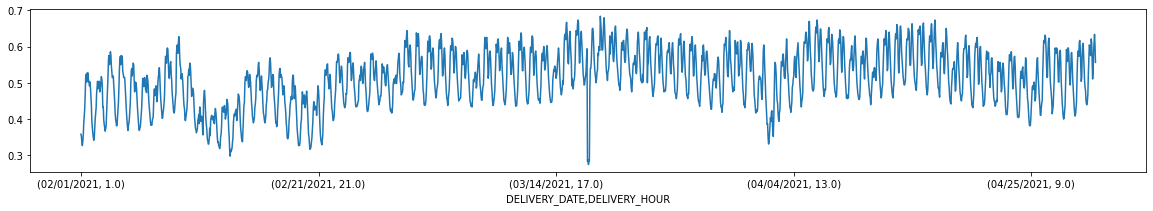

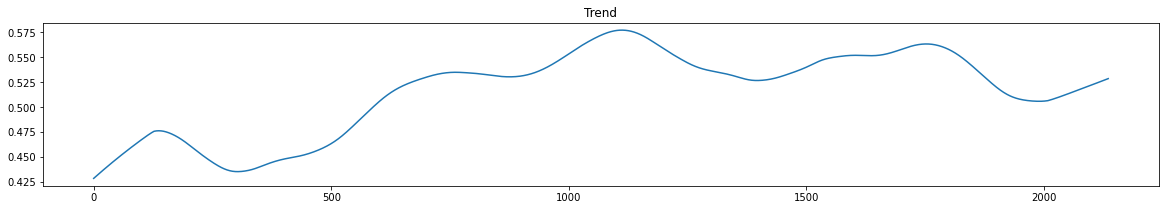

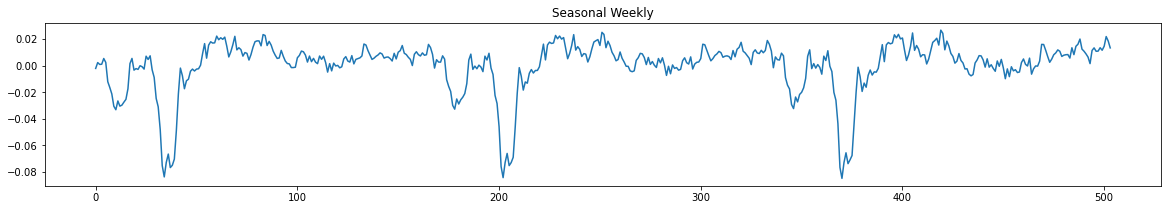

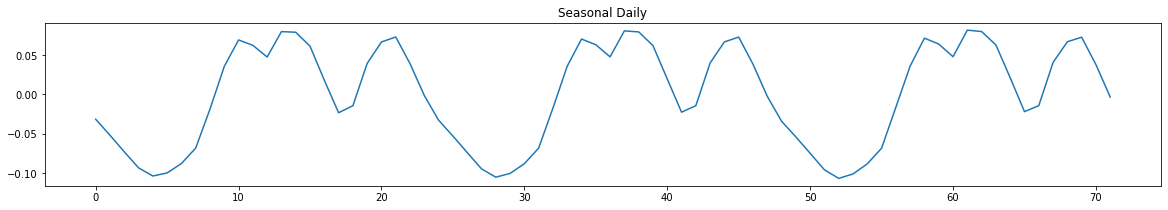

In [107]:
seasonal_weekly = res.seasonal
trend = res.trend
residual = res.resid

series.plot(figsize=(20,3))
plt.show()

pd.Series(trend).plot(figsize=(20,3), title='Trend')
plt.show()

pd.Series(seasonal_weekly[-3*7*24:]).plot(figsize=(20,3), title='Seasonal Weekly')
plt.show()

pd.Series(seasonal_daily[-3*24:]).plot(figsize=(20,3), title='Seasonal Daily')
plt.show()

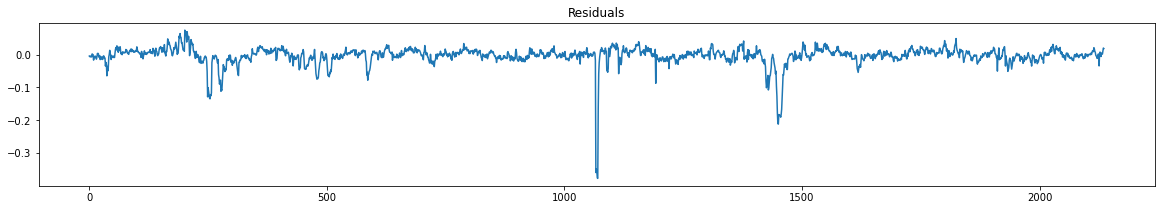

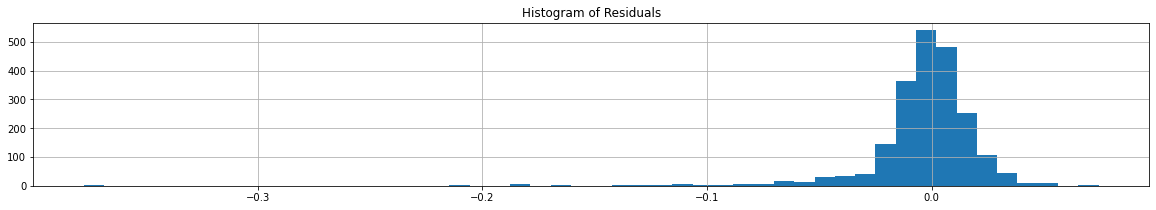

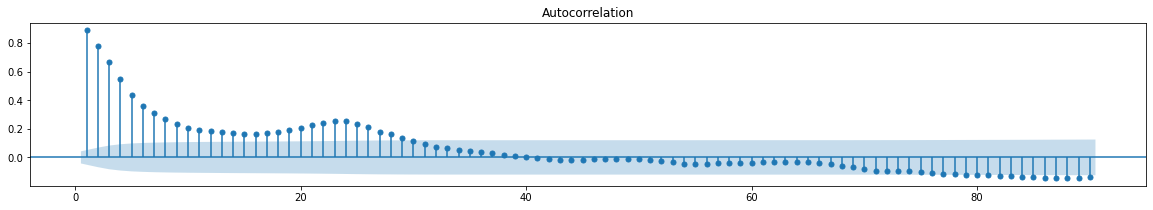

In [108]:
pd.Series(residual).plot(figsize=(20,3), title='Residuals')
plt.show()

ax = pd.Series(residual).hist(figsize=(20,3), bins=50)
ax.set_title('Histogram of Residuals')
plt.show()

fig, ax = plt.subplots(figsize=(20,3))
sm.graphics.tsa.plot_acf(residual, lags=90, zero=False, ax=ax)
plt.show()

In [ ]:
# forecasted_seasonal_daily = snaivef(seasonal_daily, h=24, m=24)
# forecasted_seasonal_weekly = snaivef(seasonal_weekly, h=24, m=24*7)

# # model = ETSModel(trend, error='add', trend='add').fit()
# # forecasted_trend = model.forecast(24)

In [ ]:
# def train_test_split(series, test_size, w, h):
#     ts_train = series[:-test_size]
#     ts_test = series[-test_size-w:]
#     return ts_train, ts_test

# def create_xy(series, w, h):
#     features, target = [], []
#     for i in range(len(series)-w-h+1):
#         features.append(series[i:i+w])
#         target.append(series[i+w: i+w+h])
#     return np.array(features), np.array(target)

In [ ]:
# w = 24*7
# h = 1
# test_size = 24

# train_x, train_y = create_xy(trend, w, h)

# model = lgb.LGBMRegressor(random_state=1).fit(train_x, train_y) 

# forecasted_trend = []
# x = np.append(train_x[-1, 1:], train_y[-1]).reshape(1,-1)

# for i in range(test_size):
#     y_hat = model.predict(x)
#     x = np.append(x[:1, 1:], y_hat).reshape(1, -1)
#     forecasted_trend.append(y_hat) 
    
# forecasted_trend = np.concatenate(forecasted_trend).ravel()

In [ ]:
# w = 24*7
# h = 1
# test_size = 24

# train_x, train_y = create_xy(residual, w, h)

# model = lgb.LGBMRegressor(random_state=1).fit(train_x, train_y) 

# forecasted_residual = []
# x = np.append(train_x[-1, 1:], train_y[-1]).reshape(1,-1)

# for i in range(test_size):
#     y_hat = model.predict(x)
#     x = np.append(x[:1, 1:], y_hat).reshape(1, -1)
#     forecasted_residual.append(y_hat) 
    
# forecasted_residual = np.concatenate(forecasted_residual).ravel()

In [ ]:
# forecasts = pd.DataFrame([forecasted_seasonal_daily, 
#                           forecasted_seasonal_weekly, 
#                           forecasted_trend, 
#                           forecasted_residual]).T
# forecasts.columns = ['Seasonal_Daily', 'Seasonal_Weekly', 'Trend', 'Residuals']
# forecasts['Total'] = forecasts.sum(axis=1)
# forecasts.head()

# total_forecast = pd.DataFrame(forecasts.sum(axis=1))
# total_forecast.head()

In [ ]:
# df_acc = pd.DataFrame()

# rmse_list = []
# mae_list = []
# mase_list = []
# rmsse_list = []

# for num, store in enumerate(tsa_train.columns[:1]):
#     mae_list.append(mae(tsa_test[store].to_numpy(), total_forecast.loc[:, num].to_numpy()))
#     rmse_list.append(rmse(tsa_test[store].to_numpy(), total_forecast.loc[:, num].to_numpy()))
#     mase_list.append(mase(tsa_test[store].to_numpy(), total_forecast.loc[:, num].to_numpy(), 
#                           tsa_train[store].to_numpy()))
#     rmsse_list.append(rmsse(tsa_test[store].to_numpy(), total_forecast.loc[:, num].to_numpy(), 
#                             tsa_train[store].to_numpy()))

# df_acc['MAE'] = np.asarray(mae_list)
# df_acc['RMSE'] = np.asarray(rmse_list)
# df_acc['MASE'] = np.asarray(mase_list)
# df_acc['RMSSE'] = np.asarray(rmsse_list)
# display(df_acc)